In [2]:
import pandas as pd
# Load the datasets
housing_data = pd.read_csv("Ames_HousePrice.csv")
real_estate_data = pd.read_csv("Ames Real Estate Data.csv")
merged_data= pd.read_csv("Cleaned_Ames_Housing_Data.csv")

C:\Users\Chloe DeRouen\AppData\Local\Temp\ipykernel_23532\120841399.py:4: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate_data = pd.read_csv("Ames Real Estate Data.csv")


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target variable
features = [
    'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageCars', 'AgeOfHouse',
    'TimeSinceLastRemodel', 'LotFrontageToLotAreaRatio', 'TotalOutdoorSpace',
    'LivingSpaceEfficiency'
]

# Ensure selected features exist
for feature in features:
    if feature not in merged_data.columns:
        print(f"Feature '{feature}' is missing in merged_data.")

X = merged_data[features]
y = merged_data['SalePrice']

# Handle missing values (if any)
X = X.fillna(X.median())
y = y.fillna(y.median())  # Optional; typically, missing target rows are removed.

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (optional for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_baseline = RandomForestRegressor(random_state=42)
rf_baseline.fit(X_train, y_train)

# Make predictions and evaluate performance
y_pred_baseline = rf_baseline.predict(X_test)

# Evaluate baseline performance
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)
print("Baseline Random Forest MSE:", mse_baseline)
print("Baseline Random Forest R^2 Score:", r2_baseline)


Baseline Random Forest MSE: 654934042.9899262
Baseline Random Forest R^2 Score: 0.898892048853195


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Perform cross-validation for MSE
cv_scores_mse = cross_val_score(
    rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)

# Convert negative MSE to positive
cv_scores_mse = -cv_scores_mse

# Perform cross-validation for R²
cv_scores_r2 = cross_val_score(
    rf_model, X_train, y_train, cv=5, scoring='r2'
)

# Print results
print(f"Cross-Validation MSE Scores: {cv_scores_mse}")
print(f"Mean CV MSE: {np.mean(cv_scores_mse)}")
print(f"Standard Deviation CV MSE: {np.std(cv_scores_mse)}")
print(f"Cross-Validation R² Scores: {cv_scores_r2}")
print(f"Mean CV R²: {np.mean(cv_scores_r2)}")
print(f"Standard Deviation CV R²: {np.std(cv_scores_r2)}")


Cross-Validation MSE Scores: [1.11758199e+09 7.27972496e+08 7.46386415e+08 6.46603188e+08
 6.64619324e+08]
Mean CV MSE: 780632682.7183626
Standard Deviation CV MSE: 172570995.88339037
Cross-Validation R² Scores: [0.80946966 0.87948373 0.85743644 0.87965064 0.86921265]
Mean CV R²: 0.8590506242004325
Standard Deviation CV R²: 0.02609987339553876


Feature Importance:
                      Feature  Importance
1                OverallQual    0.556036
0                  GrLivArea    0.200275
2                TotalBsmtSF    0.114030
4                 AgeOfHouse    0.026930
3                 GarageCars    0.023104
5       TimeSinceLastRemodel    0.022638
8      LivingSpaceEfficiency    0.019703
7          TotalOutdoorSpace    0.019311
6  LotFrontageToLotAreaRatio    0.017973


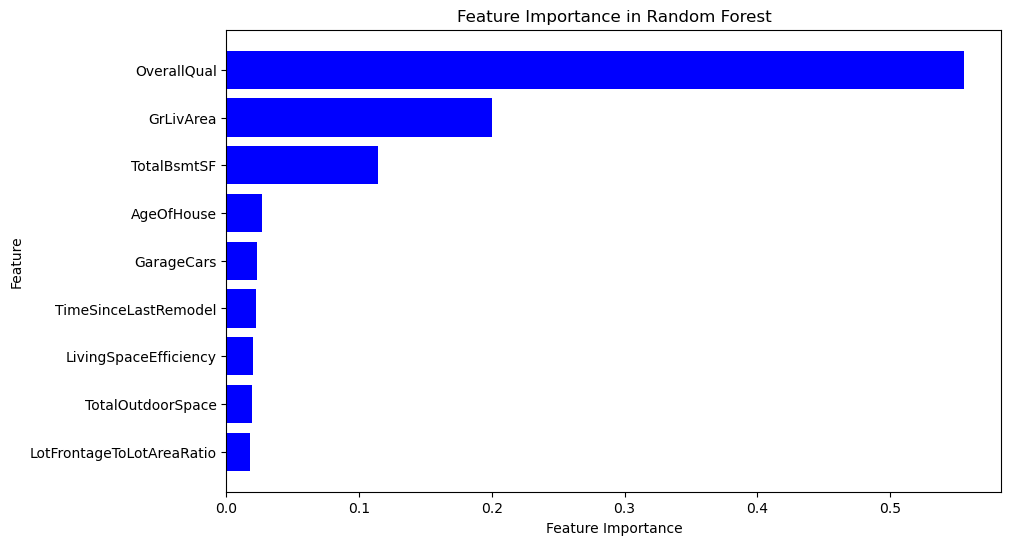

In [8]:
# Get feature importance from the baseline model
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_baseline.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


Tuned Random Forest MSE: 682147857.8062654
Tuned Random Forest R^2 Score: 0.8946908119677106


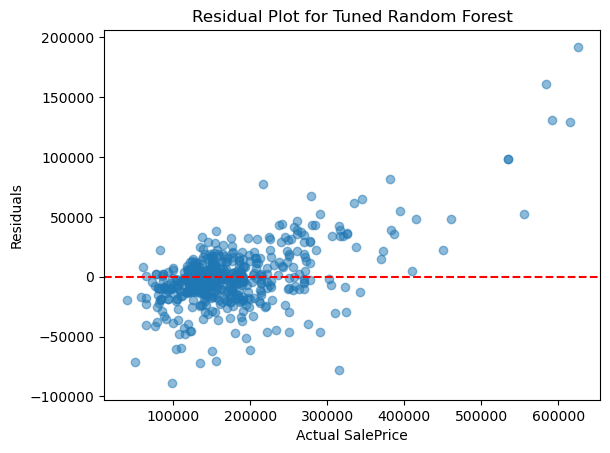

In [14]:
# Predict on the test set using the best model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate performance
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
print("Tuned Random Forest MSE:", mse_tuned)
print("Tuned Random Forest R^2 Score:", r2_tuned)

# Residual plot
residuals = y_test - y_pred_tuned
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot for Tuned Random Forest")
plt.show()


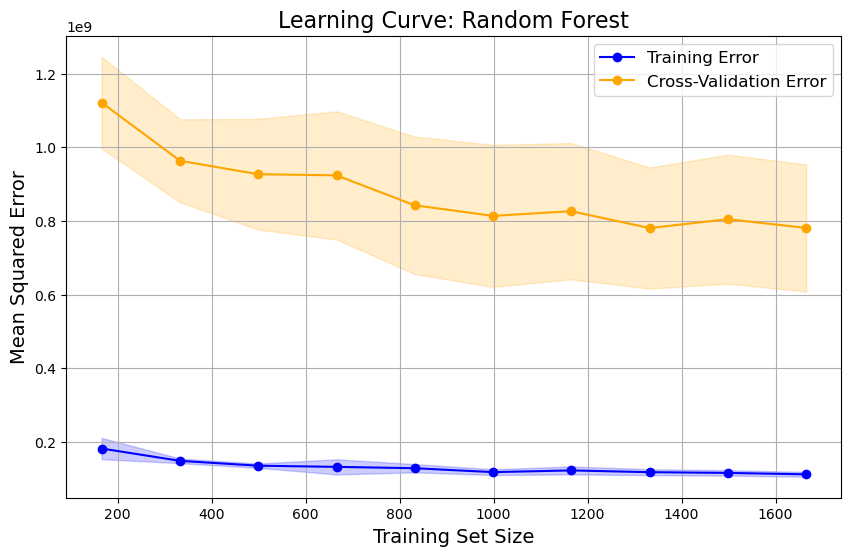

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Convert negative MSE scores to positive
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Error', color='orange', marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='orange')

# Add labels, title, and legend
plt.title('Learning Curve: Random Forest', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()



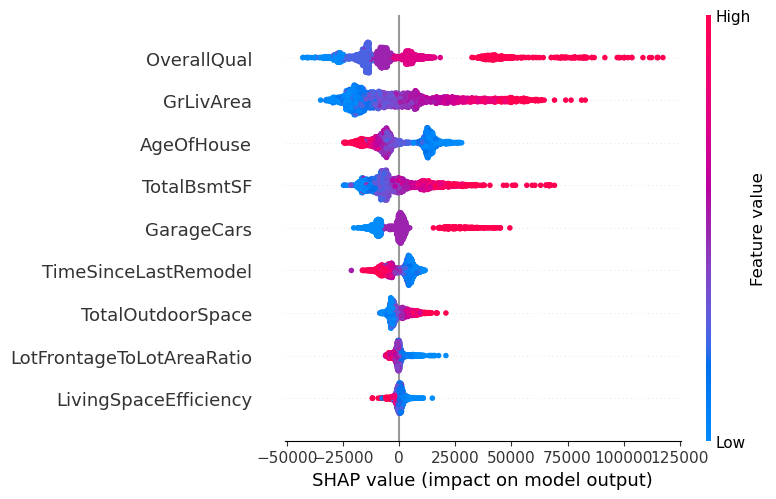

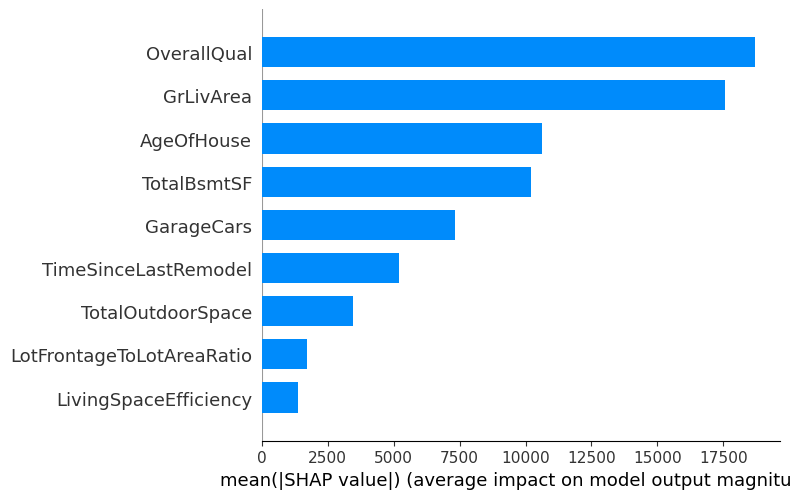

In [22]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_rf_model)

# Get SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

# SHAP feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")